# DESI PV Y1 $z$-bin TFR Calibration w/o zero-pointing

In redshift bins of width 0.001 (or 0.005), identify DESI observations with measurements suitable for the Tully-Fisher relation. Export the SGA IDs of the TFR galaxies and apply a multi-bin joint fit to calibrate the TFR at $0.4R_{26}$, weighting the galaxies in the fit by $V(z=0.2)/V_{max}$.  Only use galaxies that pass Alex's criteria cuts:
* $m_r$ < minimum of (17.75, $\mu_{CMB} - 17 + 5\log h$)
* $70 < V(0.4R_{26}) < 300$ km/s
* $V(0.4R_{26}) <$ minimum of (300 km/s, $10^{0.3(\mu_{CMB} - 34 + 5\log h) + 2}$)

Version: **30 October 2025**

**Note:** This requires using a subclassed version of `hyperfit`.

In [5]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

# We have more than 10 redshift bins, so we need to change the default color map so that they are all plotted with different colors
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

import ligo.skymap.plot

from astropy.table import Table, vstack, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from cosmoprimo.fiducial import DESI

from scipy.spatial.distance import cdist, euclidean

import os

from corner import corner

import pickle

from tqdm import tqdm

from matplotlib.projections import get_projection_names

from desiutil.plots import init_sky

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
# sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
# cosmo = DESI()

In [3]:
# Base values for later conversions (all in units in km/s).
c_kms = c.c.to_value('km/s')

h = 1.
H0 = 100*h

q0 = 0.2

# Access SGA Iron Data

The following selections have already been applied:
* `DELTACHI2 > 25` & `ZWARN = 0` for the centers
* $10 < V < 1000$ km/s and $\Delta V / V_\text{min}$ for the observations at $0.4R_{26}$
* Visual inspection

In [4]:
# sgapath = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1'
sgapath = '.'
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_photsys.fits')
# sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_dVsys_VI_photsys_v2.fits')
sgafits = os.path.join(sgapath, 'SGA-2020_iron_Vrot_VI_corr-20251030.fits')

sgatab = Table.read(sgafits)
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,2.5975581332155182e-05,122.3223893029039,11.199286747864958,N
55,SGA-2020 55,PGC12039

## Compute maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be located to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [6]:
Planck18_h = FlatLambdaCDM(H0=100, Om0=0.3151)

In [7]:
dist = Distance(z=np.abs(sgatab['Z_DESI']), cosmology=Planck18_h)

sgatab['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*sgatab['D26']*u.arcmin)

sgatab['DIST_MAX'] = 0.5*sgatab['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

sgatab['MAX_VOL_FRAC'] = sgatab['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

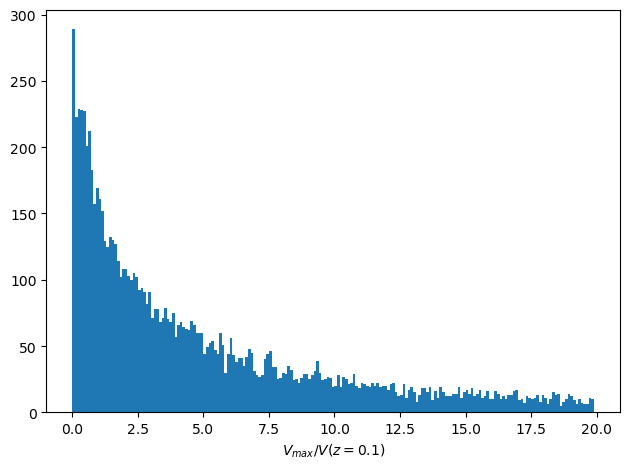

In [8]:
plt.figure(tight_layout=True)

plt.hist(sgatab['MAX_VOL_FRAC'], np.arange(0, 20, 0.1))

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

## Convert to CMB frame

In [9]:
sgatab['Z_DESI_CMB'] = convert_z_frame(sgatab['Z_DESI'], sgatab['RA'], sgatab['DEC'])

## Define dwarfs

We defined dwarfs to have $m_r$ < minimum of (17.75, $\mu_{CMB} - 17 + 5\log h$)

In [10]:
# Using Alex's notation for consistency
Rlim = 17.75
Mlim = -17 + 5*np.log10(h)

sgatab['MU_ZCMB'] = Planck18_h.distmod(sgatab['Z_DESI_CMB'])

Rlim_eff = np.minimum(Rlim, sgatab['MU_ZCMB'] + Mlim)
dwarf_boolean = sgatab['R_MAG_SB26'] > Rlim_eff

# Load Morphological Classification

## SSL

As an alternative to morphological classification of the galaxies, we also produced a classification based on the SSL sorter (using a nearest-neighbor query; Largett et al., in prep.). The classification ignored the Hubble sub-types and grouped the galaxies into four main categories:
1. Spiral
2. Elliptical
3. Lenticular
4. Irregular

Let's also load this table and add it to the SGA table.

In [11]:
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv'
ai_morphpath = '.'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
# ai_morphcsv = os.path.join(ai_morphpath, 'sga10278_morphologies_model_analysis.csv')
ai_morphcsv = os.path.join(ai_morphpath, 'TFY1_Classification.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab

SGA_ID,Spiral_Pred,Elliptical_Pred,Lenticular_Pred,Irregular_Pred
float64,str6,str10,str10,str9
2371.0,Other,Other,Other,Irregular
2406.0,Spiral,Other,Other,Other
4614.0,Spiral,Other,Other,Other
7707.0,Spiral,Other,Other,Other
8119.0,Spiral,Other,Other,Other
8832.0,Spiral,Other,Other,Other
9415.0,Other,Other,Other,Irregular
11933.0,Spiral,Other,Other,Other
12347.0,Other,Other,Other,Irregular


In [12]:
# Create an overall record of the SSL prediction
ai_morphtab['Predicted_Type'] = 'Undecided '

for i in range(len(ai_morphtab)):
    
    classes = ai_morphtab['Spiral_Pred', 'Elliptical_Pred', 'Lenticular_Pred', 'Irregular_Pred'][i]
    
    ai_morphtab['Predicted_Type'][i] = next(j for j in classes if j != 'Other')

### Combine ML morphtypes with SGA catalog

In [13]:
sgatab = join(sgatab, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
sgatab['Predicted_Type'].name = 'MORPHTYPE_AI'

## John Lucey's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We are only considering galaxies that he considers bad for TF (strong asymmetry, double galaxies, stellar contamination).

In [14]:
lucey_VIpath = 'VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

SGA_ID,DESI_NAME,RA,Dec,z_desi,V_0p4R26,V_0p4R26_err,V_PEC,V_ERR_PEC,VI
int64,str22,float64,float64,float64,int64,int64,int64,int64,str6
18171,DESIXJ21105773+0109527,317.74056,1.164637,0.0903,219,1,-555,542,reject
18900,DESIXJ13403122+0437086,205.130097,4.619043,0.0224,52,2,2647,351,reject
20828,DESIXJ20452158-0505449,311.339907,-5.095804,0.0522,97,1,9894,335,reject
24403,DESIXJ13023920-0257343,195.663329,-2.959515,0.0675,222,1,-2594,411,reject
34318,DESIXJ15173290+0109051,229.38709,1.151405,0.1257,235,38,7564,7706,reject
43314,DESIXJ19180598+6436397,289.524898,64.611027,0.0255,104,2,1327,299,reject
61768,DESIXJ23195165+0025234,349.965218,0.423153,0.0341,123,0,-305,278,reject
63092,DESIXJ14161558-0127527,214.064897,-1.46464,0.0363,149,0,-5767,286,reject
65921,DESIXJ21443087-0617367,326.12863,-6.293535,0.09,89,21,26924,8751,reject


### Combine John's results with Y1 TF sample

In [15]:
sgatab = join(sgatab, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
sgatab['VI'].name = 'JOHN_VI'

In [16]:
sgatab[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,D26_kpc,DIST_MAX,MAX_VOL_FRAC,Z_DESI_CMB,MU_ZCMB,MORPHTYPE_AI,JOHN_VI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,,mag,,
float64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,str10,str6
38.0,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.036493

# Apply Cuts Suitable for Calibrating the TFR

Requirements:
* $\Delta V/V_\mathrm{min} \leq 5$
* Passed visual inspection (both ours and John Lucey's)
* $i > 45^\circ$
* Spiral-type morphology
* Not a dwarf galaxy
* $70~\mathrm{km/s} < V_\mathrm{rot} < 300~\mathrm{km/s}$ at $0.4R_{26}$
* $\log(V_\mathrm{rot}) <$ minimum of log(300 km/s) or $0.3(\mu(z_{CMB}) - 34 - 5\log h) + 2$

The first 1.5 items have already been applied (our VI results have already been applied, but not John's).

In [17]:
#- Inclination cut
cosi2 = (sgatab['BA']**2 - q0**2) / (1 - q0**2)
i_min = 45. * u.degree
cosi2_max = np.cos(i_min)**2
is_good_incl = cosi2 < cosi2_max

#- Morphology cut: only ML
is_good_morph_ML = np.zeros_like(is_good_incl, dtype=bool)
for i in range(len(sgatab)):
    if sgatab['MORPHTYPE_AI'][i] == 'Spiral':
        is_good_morph_ML[i] = True

#- John's VI
is_good_John = sgatab['JOHN_VI'].mask

# Alex's velocity cut
Vmin = 70 # km/s
Vmax = 300 # km/s
is_good_vel = (sgatab['V_0p4R26'] > Vmin) & (sgatab['V_0p4R26'] < Vmax)

#- Alex's sliding velocity maximum
logVM_slope = 0.3
logVM_zero = 34 + 5*np.log10(h)
is_good_vel2 = sgatab['V_0p4R26'] < np.minimum(Vmax, 10**(logVM_slope*(sgatab['MU_ZCMB'] - logVM_zero) + 2))

#- Combine selections:
is_good_sga = is_good_incl & is_good_morph_ML & is_good_John & ~dwarf_boolean & is_good_vel & is_good_vel2

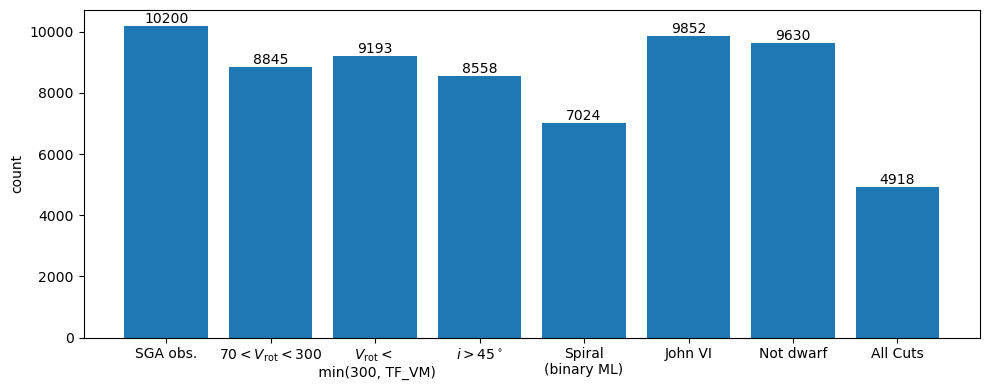

In [18]:
data = {
    'SGA obs.' : len(sgatab),
    r'$70 < V_\mathrm{rot} < 300$' : np.sum(is_good_vel),
    '$V_\mathrm{rot} <$ \n min(300, TF_VM)' : np.sum(is_good_vel2), 
    # r'$\Delta V/V_\mathrm{min}>5$' : np.sum(is_good_dv),
    r'$i > 45^\circ$' : np.sum(is_good_incl), 
    # 'Spiral' : np.sum(is_good_morph),
    'Spiral\n(binary ML)' : np.sum(is_good_morph_ML),
    'John VI' : np.sum(is_good_John), 
    'Not dwarf' : np.sum(~dwarf_boolean), 
    'All Cuts' : np.sum(is_good_sga), 
    # 'All Cuts\n(binary ML)' : np.sum(is_good_sga_ML)
}
names = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(1, 1, figsize=(10,4), tight_layout=True)
bars = ax.bar(names, values, color='tab:blue')
ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);

# fig.savefig('../../Figures/Y1/TF_Y1_SGA_Vrot_cuts.png', dpi=150, facecolor='none');

# Photometric corrections

### Survey offsets

In [19]:
sys_corr, sys_corr_err = BASS_corr(sgatab['PHOTSYS'])

### MW dust corrections

In [20]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [21]:
MWdust_corr, MWdust_corr_err = MW_dust(sgatab['RA'], sgatab['DEC'], ebv_map)

/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [22]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [23]:
# Apparently we have some galaxies with negative redshifts
zg0 = sgatab['Z_DESI'] >= 0

In [24]:
kcorr_zg0 = k_corr(sgatab['Z_DESI'][zg0], 
                   [sgatab['G_MAG_SB26'][zg0], sgatab['R_MAG_SB26'][zg0], sgatab['Z_MAG_SB26'][zg0]], 
                   [sgatab['G_MAG_SB26_ERR'][zg0], sgatab['R_MAG_SB26_ERR'][zg0], sgatab['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # K-correcting to same redshift as FastSpecFit (which is what Caitlin's using for the FP)

In [25]:
kcorr = np.zeros([len(sgatab), 3])
kcorr[zg0] = kcorr_zg0

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [26]:
temp_infile = open('iron_internalDust_z0p1_mcmc_09092025.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [27]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [28]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(sgatab['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

## Apply corrections

In [29]:
sgatab['G_MAG_SB26_CORR'] = sgatab['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
sgatab['R_MAG_SB26_CORR'] = sgatab['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
sgatab['Z_MAG_SB26_CORR'] = sgatab['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [30]:
sgatab['G_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
sgatab['R_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
sgatab['Z_MAG_SB26_ERR_CORR'] = np.sqrt(sgatab['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

# Redshift bins

Separate the galaxies into redshift bins of width 0.005, starting at a redshift of 0.03.  (PVs are a significant fraction of the redshift at redshifts less than this.)

In [37]:
zmin = 0.03
zmax = 0.1
dz = 0.005
zbins = np.arange(zmin, zmax, dz)

#- SGA galaxies that passed quality selection
sgatab_sel = sgatab[is_good_sga]

zbin_indices = np.digitize(sgatab_sel['Z_DESI_CMB'], zbins, right=True)

In [38]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices == i):3d} galaxies')

 0  z <= 0.030  292 galaxies
 1  0.030 < z <= 0.035  336 galaxies
 2  0.035 < z <= 0.040  309 galaxies
 3  0.040 < z <= 0.045  321 galaxies
 4  0.045 < z <= 0.050  350 galaxies
 5  0.050 < z <= 0.055  354 galaxies
 6  0.055 < z <= 0.060  310 galaxies
 7  0.060 < z <= 0.065  327 galaxies
 8  0.065 < z <= 0.070  317 galaxies
 9  0.070 < z <= 0.075  293 galaxies
10  0.075 < z <= 0.080  297 galaxies
11  0.080 < z <= 0.085  299 galaxies
12  0.085 < z <= 0.090  242 galaxies
13  0.090 < z <= 0.095  165 galaxies
14  0.095 < z <= 0.100  116 galaxies
15  z > 0.100  590 galaxies


In [39]:
_, counts = np.unique(zbin_indices, return_counts=True)

print(np.min(counts[1:-1]), np.max(counts[1:-1]))

116 354


# Build the Calibration Table of SGA Galaxies

In [40]:
sgatab_sel['Z_BIN_IDX'] = zbin_indices

no_use = (zbin_indices == 0) | (zbin_indices == len(zbins))
caltab = sgatab_sel[~no_use]

rejtab = sgatab_sel[no_use]

# caltab.write('SGA-2020_iron_Vrot_cluster_calib_z0p1_Anthony2_dVsys.fits', overwrite=True)
caltab[['Z_BIN_IDX', 'Z_DESI_CMB', 'SGA_ID', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'V_0p4R26', 'V_0p4R26_ERR']]

Z_BIN_IDX,Z_DESI_CMB,SGA_ID,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,V_0p4R26,V_0p4R26_ERR
int64,float64,float64,float64,float64,float64,float64
11,0.08162327483927467,38.0,16.72591931744365,0.10891453901543764,122.3223893029039,11.199286747864958
13,0.09120074612338591,117.0,15.951266535825447,0.11209142976905018,180.6557315191658,13.703729472844426
4,0.04770393135250317,1158.0,14.815759447532493,0.10730342458269317,177.66056756020413,10.807692195383957
6,0.05517343391109497,1358.0,14.471689442244486,0.06505903660364454,199.4451387681563,7.056645577450859
7,0.06211147463081468,1548.0,16.457867660710914,0.0957838599578687,169.1324952933182,11.348288780198054
6,0.05541189869150731,1663.0,16.26528758501003,0.134244926140507,140.65283727627954,10.556076881774143
10,0.07868601783175921,1849.0,15.209336190356687,0.07131437708516183,224.37660060768928,8.403307854639687
4,0.048805933559745496,1996.0,16.690067772911092,0.08861948371358802,125.94703026320882,12.656288883448726
14,0.09620790749304664,2308.0,16.37916696805872,0.07804800062650175,149.561381564212,13.254163426872788


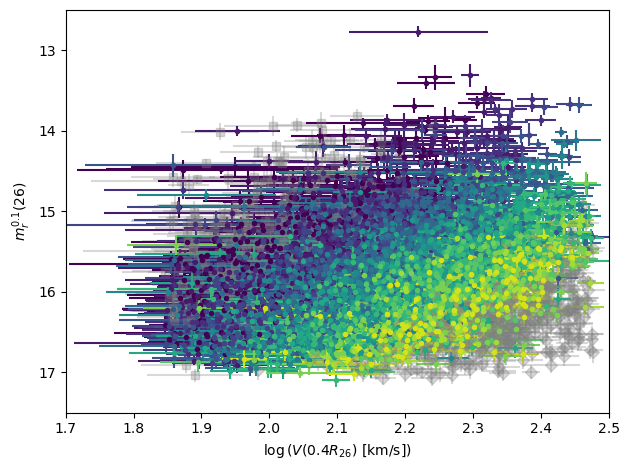

In [36]:
# fig, axes = plt.subplots(1, 2, figsize=(8,6), sharex=True, tight_layout=True)
fig, axes = plt.subplots(1, 1, tight_layout=True)

logV0 = 0

# ax = axes[0] 
ax = axes

#-------------------------------------------------------------------------------
# Plot galaxies with failed cluster selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(rejtab['Z_BIN_IDX'])
markers = 'sDv^<>'
for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(rejtab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(rejtab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*rejtab['V_0p4R26_ERR'][select_zbin].data / rejtab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = rejtab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = rejtab['R_MAG_SB26_ERR_CORR'][select_zbin].data

    if _zbin_id == 0:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z $\leq$ {zbins[_zbin_id]:.3f} (rej.)')
    else:
        ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, 
                    fmt=markers[j % 2], markersize=6, color='gray', alpha=0.3, 
                    label=f'z > {zbins[_zbin_id-1]:.3f} (rej.)')
#-------------------------------------------------------------------------------
# Plot galaxies and clusters passing all selections.
#-------------------------------------------------------------------------------
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,len(_zbin_ids)+1)))

for _zbin_id in _zbin_ids:
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)

    #- Store independent variable for each cluster
    logv = np.log10(caltab['V_0p4R26'][select_zbin].data) - logV0
    logv_err = 0.434*caltab['V_0p4R26_ERR'][select_zbin].data / caltab['V_0p4R26'][select_zbin].data

    #- Store dependent variable for each cluster
    mr26 = caltab['R_MAG_SB26_CORR'][select_zbin].data
    mr26_err = caltab['R_MAG_SB26_ERR_CORR'][select_zbin].data
    
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err, fmt='.', 
                label=f'{zbins[_zbin_id-1]:.3f}-{zbins[_zbin_id]:.3f}')
#-------------------------------------------------------------------------------

ax.set(xlim=[1.7, 2.5],
       xlabel=r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)',
       ylim=[17.5, 12.5],
       ylabel=r'$m_r^{0.1} (26)$');

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_20241203.png', dpi=150);

# Apply the Joint TFR Fit

In [41]:
#- Extract redshift bins
_zbin_ids = np.unique(caltab['Z_BIN_IDX'])
m = len(_zbin_ids)

#- Pack the results into arrays data and cov.
logV, logV_err = [], []
mag, mag_err = [], []
weights = []

logV0 = np.median(np.log10(caltab['V_0p4R26']))
print('logV0 =', logV0)

#- Loop over the redshift bins
for k, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(caltab['Z_BIN_IDX'], _zbin_id)
    logV.append(np.log10(caltab['V_0p4R26'][select_zbin]) - logV0)
    logV_err.append(0.434*caltab['V_0p4R26_ERR'][select_zbin] / caltab['V_0p4R26'][select_zbin])
    mag.append(caltab['R_MAG_SB26_CORR'][select_zbin])
    mag_err.append(caltab['R_MAG_SB26_ERR_CORR'][select_zbin])
    weights.append(np.array(1/caltab['MAX_VOL_FRAC'][select_zbin]))

logV0 = 2.1798415590850277


## Multiline Fit using HyperFit

In [42]:
bounds = [[-20, 0]]                    # Bounds on a (slope)
bounds += m*[(-20, 20)]                # Bounds on b (intercepts: z-bins)
bounds += [(0,5)]                      # Bounds on sigma

results = hyperfit_line_multi(logV, mag, logV_err, mag_err, bounds, weights=weights, scatter=1)

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

             message: Optimization terminated successfully.
             success: True
                 fun: -872585.7826042206
                   x: [-7.154e+00  1.443e+01 ...  1.693e+01  4.432e-01]
                 nit: 171
                nfev: 41603
          population: [[-7.149e+00  1.443e+01 ...  1.693e+01  4.429e-01]
                       [-7.157e+00  1.443e+01 ...  1.693e+01  4.434e-01]
                       ...
                       [-7.155e+00  1.443e+01 ...  1.693e+01  4.426e-01]
                       [-7.154e+00  1.443e+01 ...  1.694e+01  4.428e-01]]
 population_energies: [-8.726e+05 -8.726e+05 ... -8.726e+05 -8.726e+05]
                 jac: [-1.034e+01  1.125e+01 ... -7.381e+00 -3.757e+01]
Ndim: 16 14


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.04it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [69.79258575 55.39060337 49.70949869 59.74933411 59.68230254 56.15344849
 72.38723805 60.2660993  57.13713047 61.54372881 65.60989247 62.40198114
 60.29509976 79.56349101 61.30081801 68.30784084] / 3978.1745507200676


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.07it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [98.45933491 59.0749821  55.60441077 68.86377904 66.34202295 69.58505445
 79.22669371 72.87463191 73.70378759 82.73617392 85.25672522 78.05056137
 86.97618966 90.65032373 88.77001613 93.01606295] / 4922.96674536044


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.96it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [103.10204241  59.39065095  60.3613428   69.23825784  67.78773513
  76.36730153  82.81461533  83.83263727  79.52224882  89.92238857
  84.70972337  91.28082     94.39743455 100.47837833 101.49965389
 111.31979158] / 5565.989579247696


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.02it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [108.91514276  66.74451421  59.30707148  71.1329924   84.23310693
  82.18994934  84.9741244   99.03502829  85.48887324  87.13275774
 105.56293196 104.59074282 110.16276776 106.92066894 116.13711797
 111.30029264] / 5806.85589871212


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.60it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [109.65550221  65.33769851  58.50387644  73.30759486  83.82753327
  80.97600705  85.61450917  95.36503415  91.27696513  93.69244527
  95.75870097 103.51655045 113.44245155 117.90947263 128.33930545
 125.96277041] / 6416.965272320428


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.85it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [121.12158672  63.88675442  65.33995064  84.69218365  90.59220882
  80.09915018  99.65000175 104.51972218  92.10484013 106.37713153
  97.71915475 103.0583041  115.91281855 112.0762888  135.91247127
 125.99512451] / 6795.623563520351


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.88it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [123.1676168   65.37527284  68.50314164  86.77474232  90.35720482
  79.2116954   98.26382317 102.35248777  95.24853227 110.13524662
 104.88781126 100.41838037 112.32105349 123.2198062  144.03295213
 137.76362504] / 7201.647606490521


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.87it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [128.94108505  62.940583    68.59253134  88.82562191  96.62690104
  77.68693548  96.34666427  98.75400491  98.56405212 113.48124817
 103.53221004 106.79043831 121.56273183 125.53297673 147.56181495
 145.31330906] / 7378.090747725082


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.00it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [143.12482351  65.34415657  68.4091872   88.4593647   91.66437438
  76.89821194  97.13863594  98.97342407  97.99021325 112.5577349
 106.78692643 110.29623519 128.26663881 128.78913568 148.58020419
 155.42594219] / 7771.297109499822


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.85it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [146.17396294  65.79713271  70.06678085  88.97755949  97.09850085
  78.63634219  98.94878347 100.71413749 102.90401094 114.46203215
 115.50532168 111.12396826 131.93557355 138.09783294 144.00009655
 149.75739006] / 7487.86950323169


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.71it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [154.70169521  65.92389743  70.18536282  88.18786779  96.6485977
  79.96178666  95.9364126  104.11462556 107.01206697 115.63240921
 115.95187723 112.18387428 130.75132166 138.98562414 143.83006622
 156.36654597] / 7818.327298301807


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.67it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [154.40063522  68.03983791  66.84106971  87.6543057   95.33339073
  82.39248154  94.48300297 107.091479   107.64933013 113.51933349
 117.46708249 115.30427227 129.48498234 139.79904253 145.55130121
 154.34514196] / 7720.031761160079


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.83it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.47262107  67.67430894  66.82767443  82.40311398  94.24176129
  84.39247687  93.6648101  106.36301761 108.06562084 110.3148097
 126.58482447 124.97828101 131.81554444 146.19377164 153.53272568
 156.7403605 ] / 8073.631053326014


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 64.96it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [160.01271845  67.81141632  69.25801946  84.17719909  95.47850993
  85.40668184  95.79685139 111.23208185 107.1821694  113.80890594
 125.36441164 126.88185753 129.79363579 146.01774643 152.38109342
 156.58867992] / 8000.63592230109


In [43]:
temp_outfile = open('cov_ab_iron_jointTFR_varyV0-dwarfsAlex_z0p1_zbins0p005_weightsVmax-1_dVsys_20251030.pickle', 
                    'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins), temp_outfile)
temp_outfile.close()

In [44]:
# temp_infile = open('cov_ab_iron_jointTFR_v14.pickle', 'rb')
# cov_tfr, tfr_mcmc_samples, logV0, zmin, zmax, dz, zbins = pickle.load(temp_infile)
# temp_infile.close()

In [53]:
values = np.median(tfr_mcmc_samples, axis=1)
sigmas = np.sqrt(np.diag(cov_tfr))

multiple = 3.5

limits = []

for i in range(len(values)):
    limits.append([values[i] - multiple*sigmas[i], 
                   values[i] + multiple*sigmas[i]])

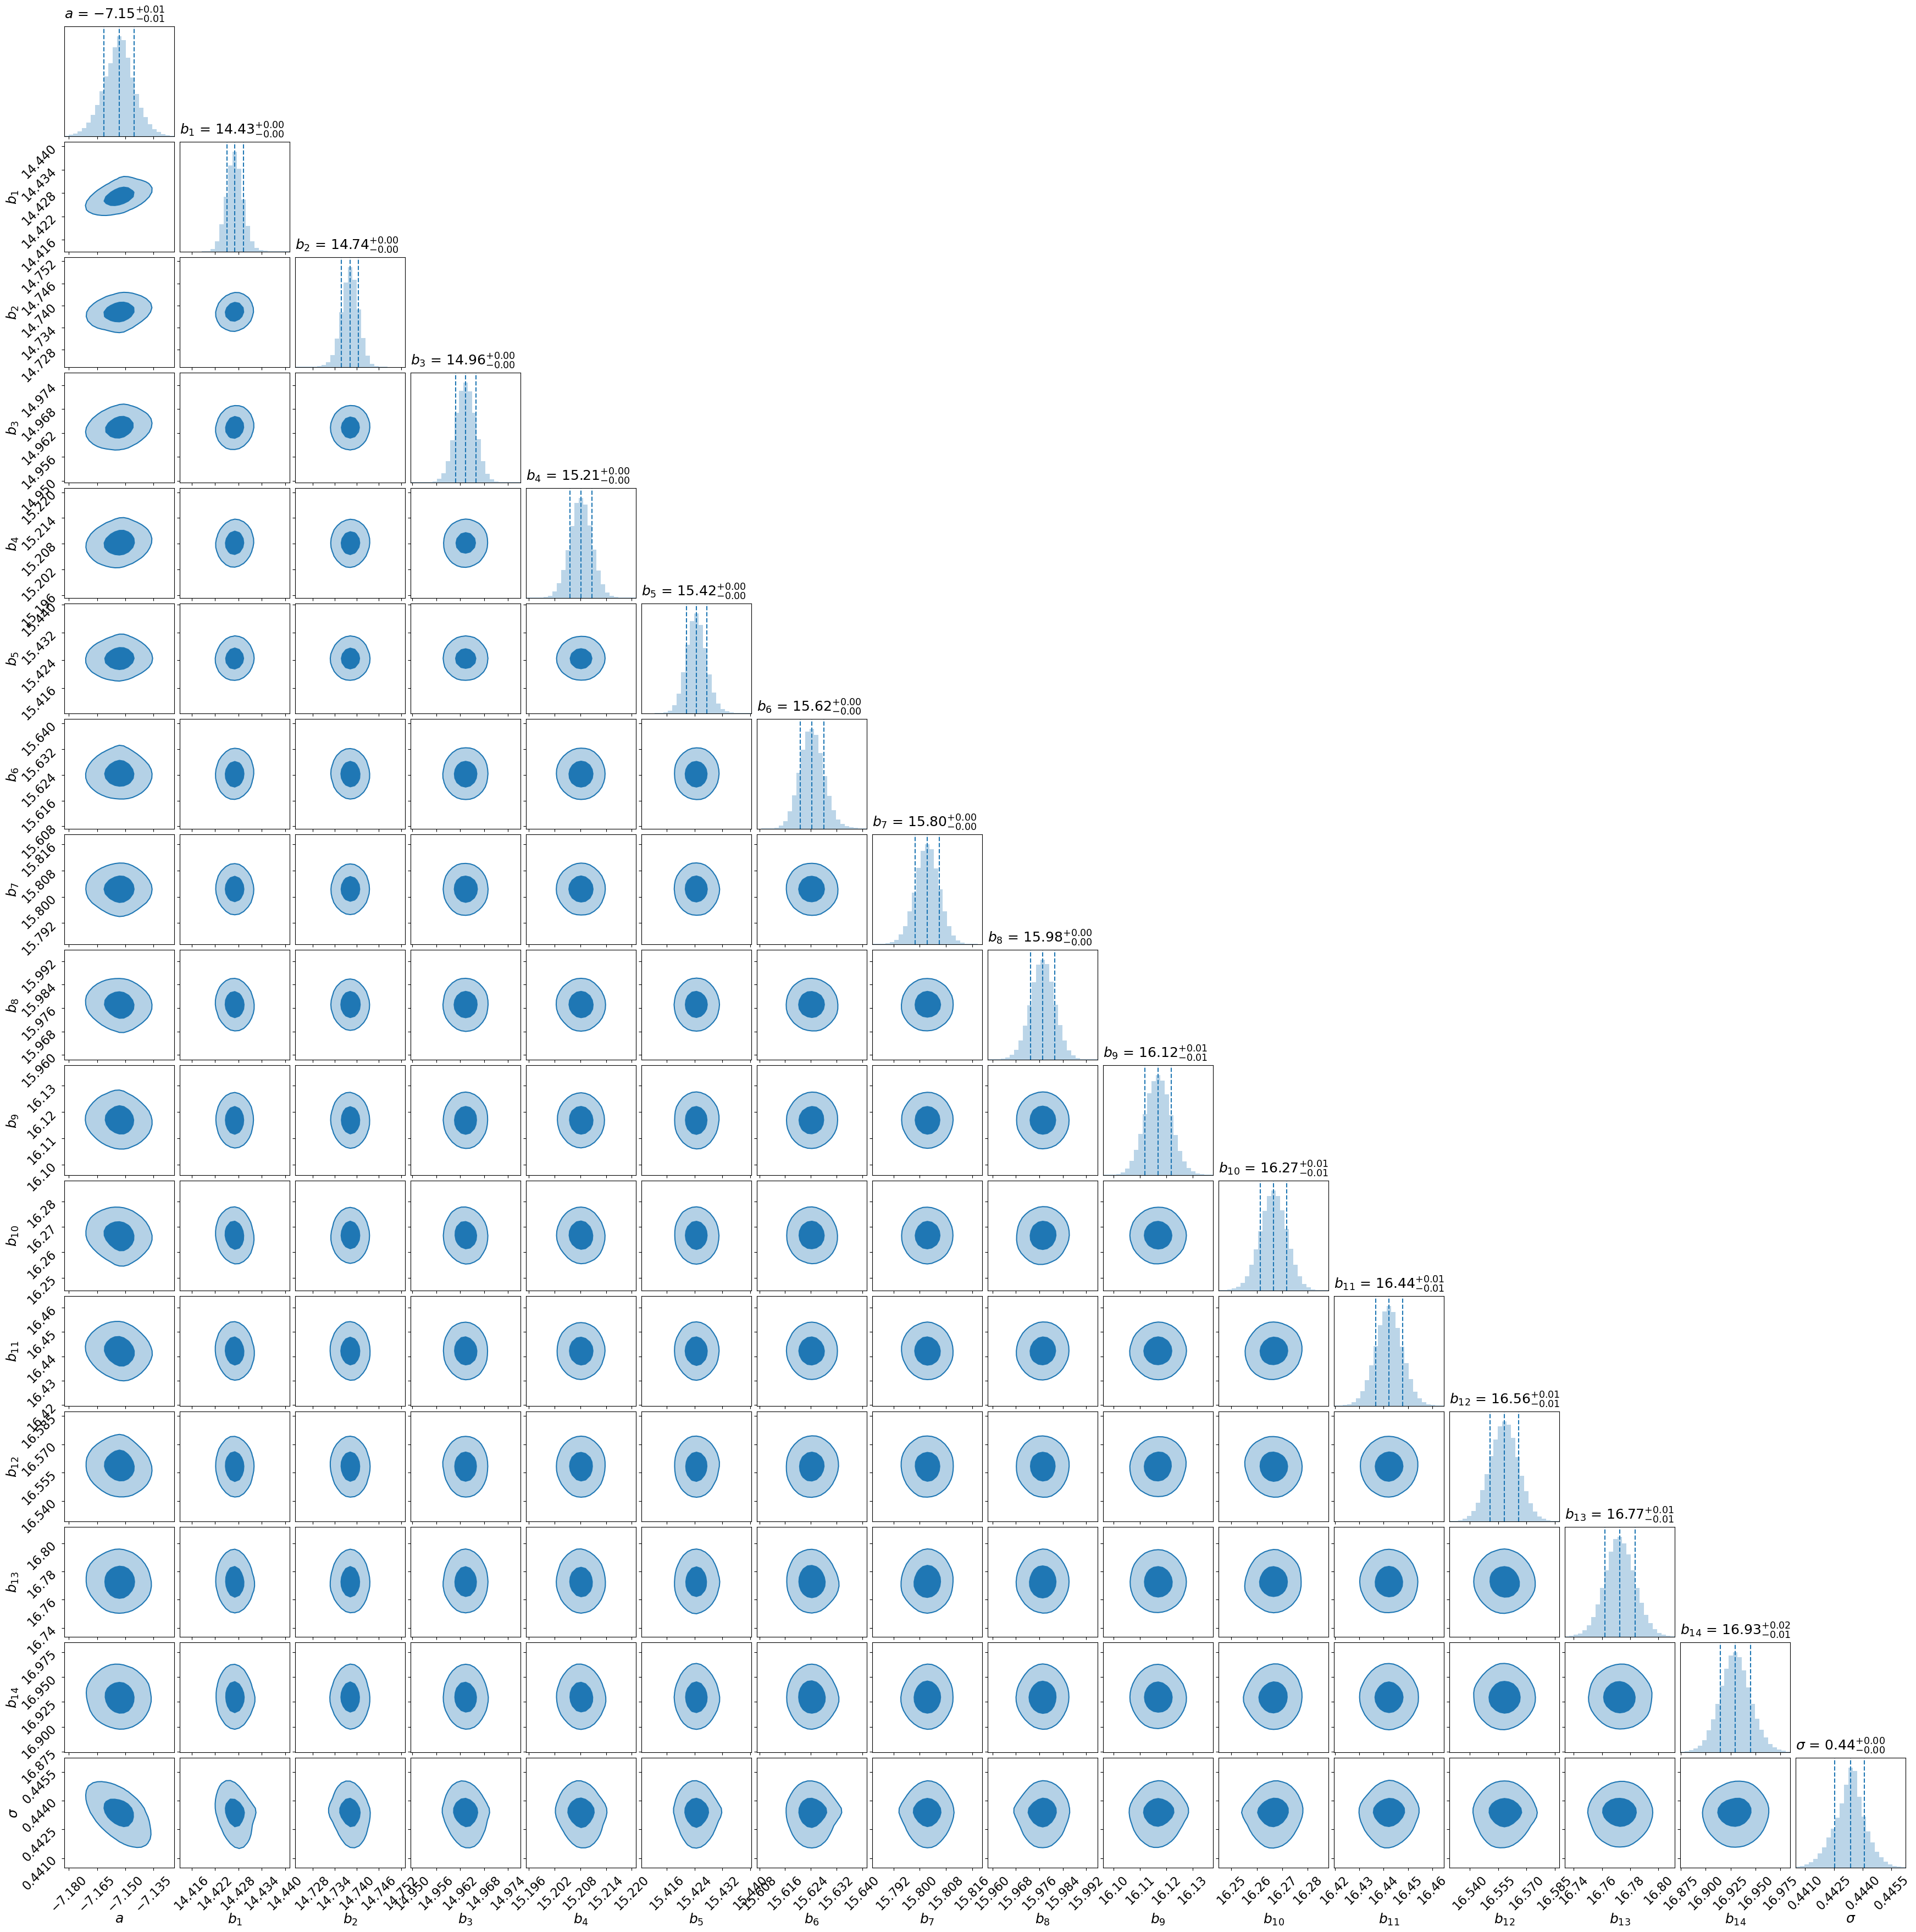

In [54]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$']

fig = corner(tfr_mcmc_samples.T, bins=25, smooth=1,
             range=limits,
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_corner0_20250717.png', 
#             dpi=150, 
#             facecolor='none');

### Plot the HyperFit Results

In [46]:
sigma_mcmc = np.percentile(tfr_mcmc_samples[-1], [16., 50., 84.])
a_mcmc = np.percentile(tfr_mcmc_samples[0], [16., 50., 84])
b_mcmc = []
for k in range(1, m+1):
    b_mcmc.append(np.percentile(tfr_mcmc_samples[k], [16., 50., 84.]))
b_mcmc = np.asarray(b_mcmc)

In [47]:
print(sigma_mcmc[1], '+', sigma_mcmc[2]-sigma_mcmc[1], ', -', sigma_mcmc[1]-sigma_mcmc[0])

0.443375032647921 + 0.0007102071050807401 , - 0.0008343232766349074


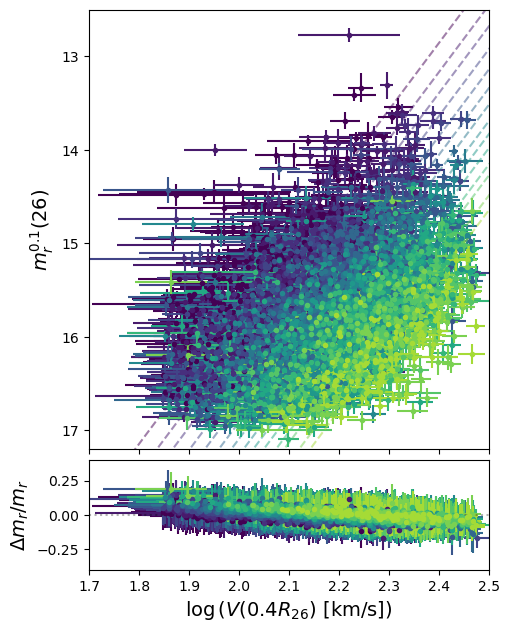

In [48]:
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True,
                         gridspec_kw={'height_ratios':[4,1], 'hspace':0.04, 'wspace':0.25})

a_   = a_mcmc[1]
b_   = b_mcmc[:,1]

#- Plot redshift bins
ax = axes[0]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = ax.errorbar(x=logV0 + logV[k],
                     y=mag[k],
                     xerr=logV_err[k],
                     yerr=mag_err[k],
                     fmt='.', 
                     label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    ax.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

ax.set(xlim=[1.7, 2.5],
       ylim=[17.2, 12.5])
ax.set_ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
# ax.legend(loc='upper left', fontsize=9, ncol=2);

#- Plot residuals: z-bins
ax = axes[1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

for k in range(m):
    logv_obs = logV[k]
    m_obs = mag[k]
    m_exp = (a_*logv_obs + b_[k])
    eb = ax.errorbar(x=logv_obs + logV0, y=(m_exp-m_obs)/m_exp, 
                     xerr=logV_err[k],
                     yerr=mag_err[k],
                     fmt='.')

ax.axhline(0, ls=':', color='k', alpha=0.3)

ax.set(ylim=[-0.4, 0.4])
ax.set_xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14)
ax.set_ylabel(r'$\Delta m_r/m_r$', fontsize=14)

fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9);

# fig.savefig('../../Figures/Y1/TF_Y1_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')

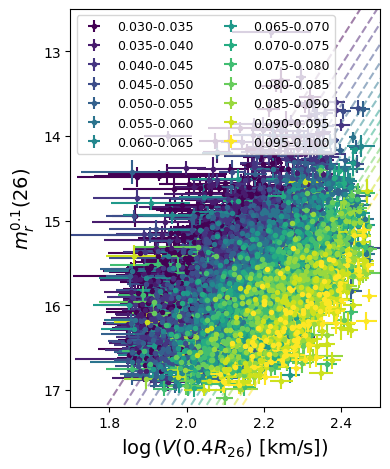

In [49]:
plt.figure(figsize=(4,4.8), tight_layout=True)

a_   = a_mcmc[1]
b_   = b_mcmc[:,1]

plt.rcParams['axes.prop_cycle'] = plt.cycler('color', plt.cm.viridis(np.linspace(0,1,m)))

_logv = np.arange(0, 3, 0.1) - logV0
for k in range(m):
    eb = plt.errorbar(x=logV0 + logV[k],
                      y=mag[k],
                      xerr=logV_err[k],
                      yerr=mag_err[k],
                      fmt='.', 
                      label=f'{zbins[k]:.3f}-{zbins[k+1]:.3f}')

    plt.plot(_logv + logV0, a_*_logv + b_[k], color=eb[0].get_color(), ls='--', alpha=0.5)

plt.xlim([1.7, 2.5])
plt.ylim([17.2, 12.5])
plt.ylabel(r'$m_r^{0.1} (26)$', fontsize=14)
plt.xlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)', fontsize=14);

plt.legend(loc='upper left', fontsize=9, ncol=2);

# plt.savefig('../../../figures/Y1_papers/TF_Y1_zbin_calibration_dz0p005_Anthony2_weightsVmax-1_20250810.png', 
#             dpi=150, 
#             facecolor='none')

In [51]:
print(f'slope (alpha): {-a_/2.5:.3f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

slope (alpha): 2.861 +/- 0.003


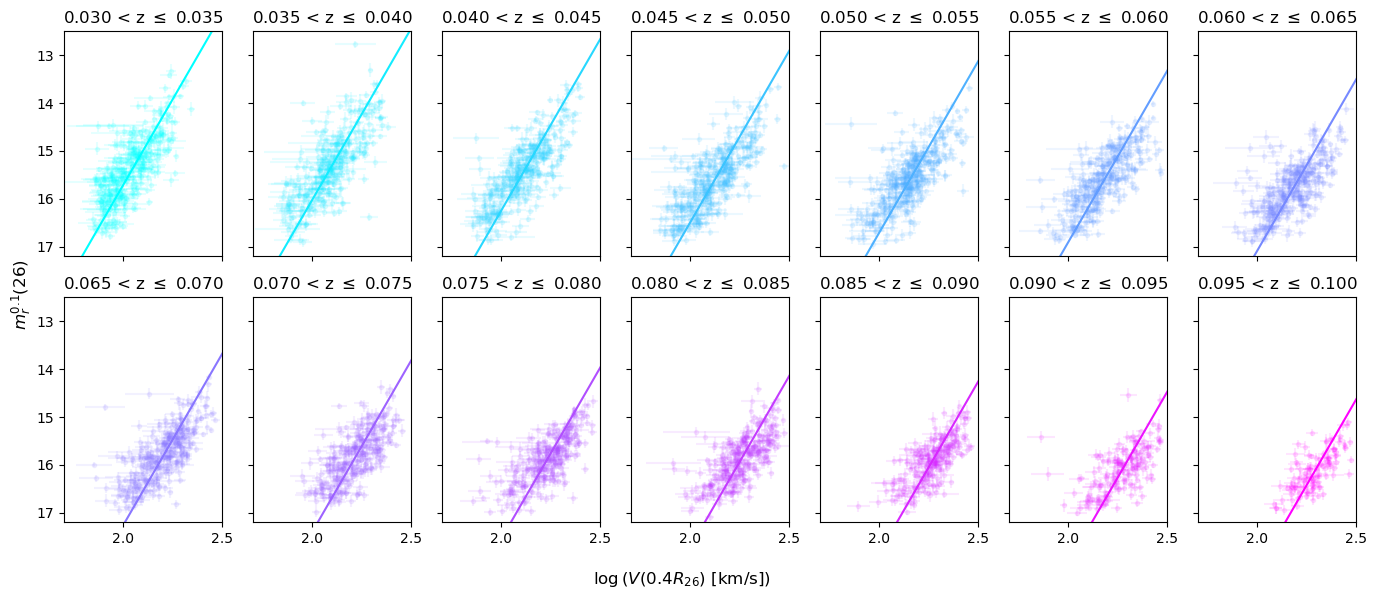

In [52]:
# fig, axs = plt.subplots(nrows=7, ncols=10, sharex=True, sharey=True, figsize=(20,16), tight_layout=True)
fig, axs = plt.subplots(nrows=2, ncols=7, sharex=True, sharey=True, figsize=(14,6), tight_layout=True)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)
    
    row = int(i/7)
    col = i%7
    
    eb = axs[row,col].errorbar(logV0 + logV[i],
                               mag[i],
                               xerr=logV_err[i],
                               yerr=mag_err[i],
                               fmt='.', color=c, alpha=0.1)
    axs[row,col].plot(_logv + logV0, a_*_logv + b_[i], color=c)
    
    axs[row,col].set(xlim=[1.7, 2.5], ylim=[17.2, 12.5], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')

# Delete extra axes
# fig.delaxes(axs[-1,-1])

fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

# plt.savefig('../../Figures/Y1/TF_Y1_individual_cluster_calibration_0pt_binaryMLupdated_z0p1_Anthony2_weightsVmax-1_dVsys_fit0_20250717.png', 
#             dpi=150, 
#             facecolor='none')